In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Valuing Risk for European Securities Guide

Note: Build model for Time Series ARCH/GARCH European Securities. Compare with Deep Learning Model for VaR European Securities risk analysis report forecasting volatitlity for portfolio. For Risk Based projects. (Two More).

Second Project: Credit Risk Model – PD, LGD, EAD Estimation

Concepts: 
 - Compount interest
- Option pricing
- Options trading
- Portfolio hedging
- Risk management

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.optimize import minimize

# Concept

For time series finance related data a core concept to note is use of continuous interest rates for modeling financial assets.

$FV = e^{rn}PV$

$PV = \frac{FV}{e^{rn}}$

$r = \frac{ln(\frac{FV}{PV})}{n}$

# Determing the prices of European Securities

Financial theory states two useful ways to value prices of options.

1. Binomial Lattice
2. Black Scholes

## Binomial Lattice (European Call Options)

Theory: Binomial Lattice models are used for pricing options under the assumption a stock goes up or down by a certain amount. The stock price follows a random path, the models structure involves nodes containing the option pricing at a given time series. Recursion is used to to compute time steps to determine the price of an option. Risk free rate for discounted cash flow, during each time period a stock goes up or down by a percentage mark. The stock price is also determined by the volatility and specific time period.

# Up and Down Factors

$u = e^{\sigma \sqrt{\Delta}t}$

$d = e^{-\sigma \sqrt{\Delta}t}$

In [12]:
var = 0.1
std = np.sqrt(var)
stock_price = 100
strike_price = 30
time_period = 2/12
risk_free_rate = 0.05
delta_time_steps = 1/12
discount_rate = np.exp(risk_free_rate * delta_time_steps)

up = np.exp(std * (np.sqrt(delta_time_steps)))
down = np.exp(-std * (np.sqrt(delta_time_steps)))

def binomial_pricing(rate, price_up, price_down, up, down):
    """
    Used for computing european option pricing for first stage of binomial lattice model
    """
    dividend_yield = (rate - price_up) / (up - down)
    return (1/rate) * (dividend_yield * price_up + (1 - dividend_yield) * price_down)


# Two Step Call Option Pricing

Compute the price of a call option based on two steps in one month by starting at the end of the tree. 

In [13]:
up_down = np.maximum(0,up * down * stock_price - strike_price)
c_uu = np.maximum(0, up ** 2 * stock_price - strike_price)
c_dd = np.maximum(0, down ** 2 * stock_price - strike_price)

In [14]:
print("--- Computed Results ---")
print(up_down)
print(c_uu)
print(c_dd)

--- Computed Results ---
69.99999999999999
90.0303193145405
53.31228357224403


# Binomial Lattice Plotting

Visual of the model for option pricing, look at up and down scenarios for each time step.

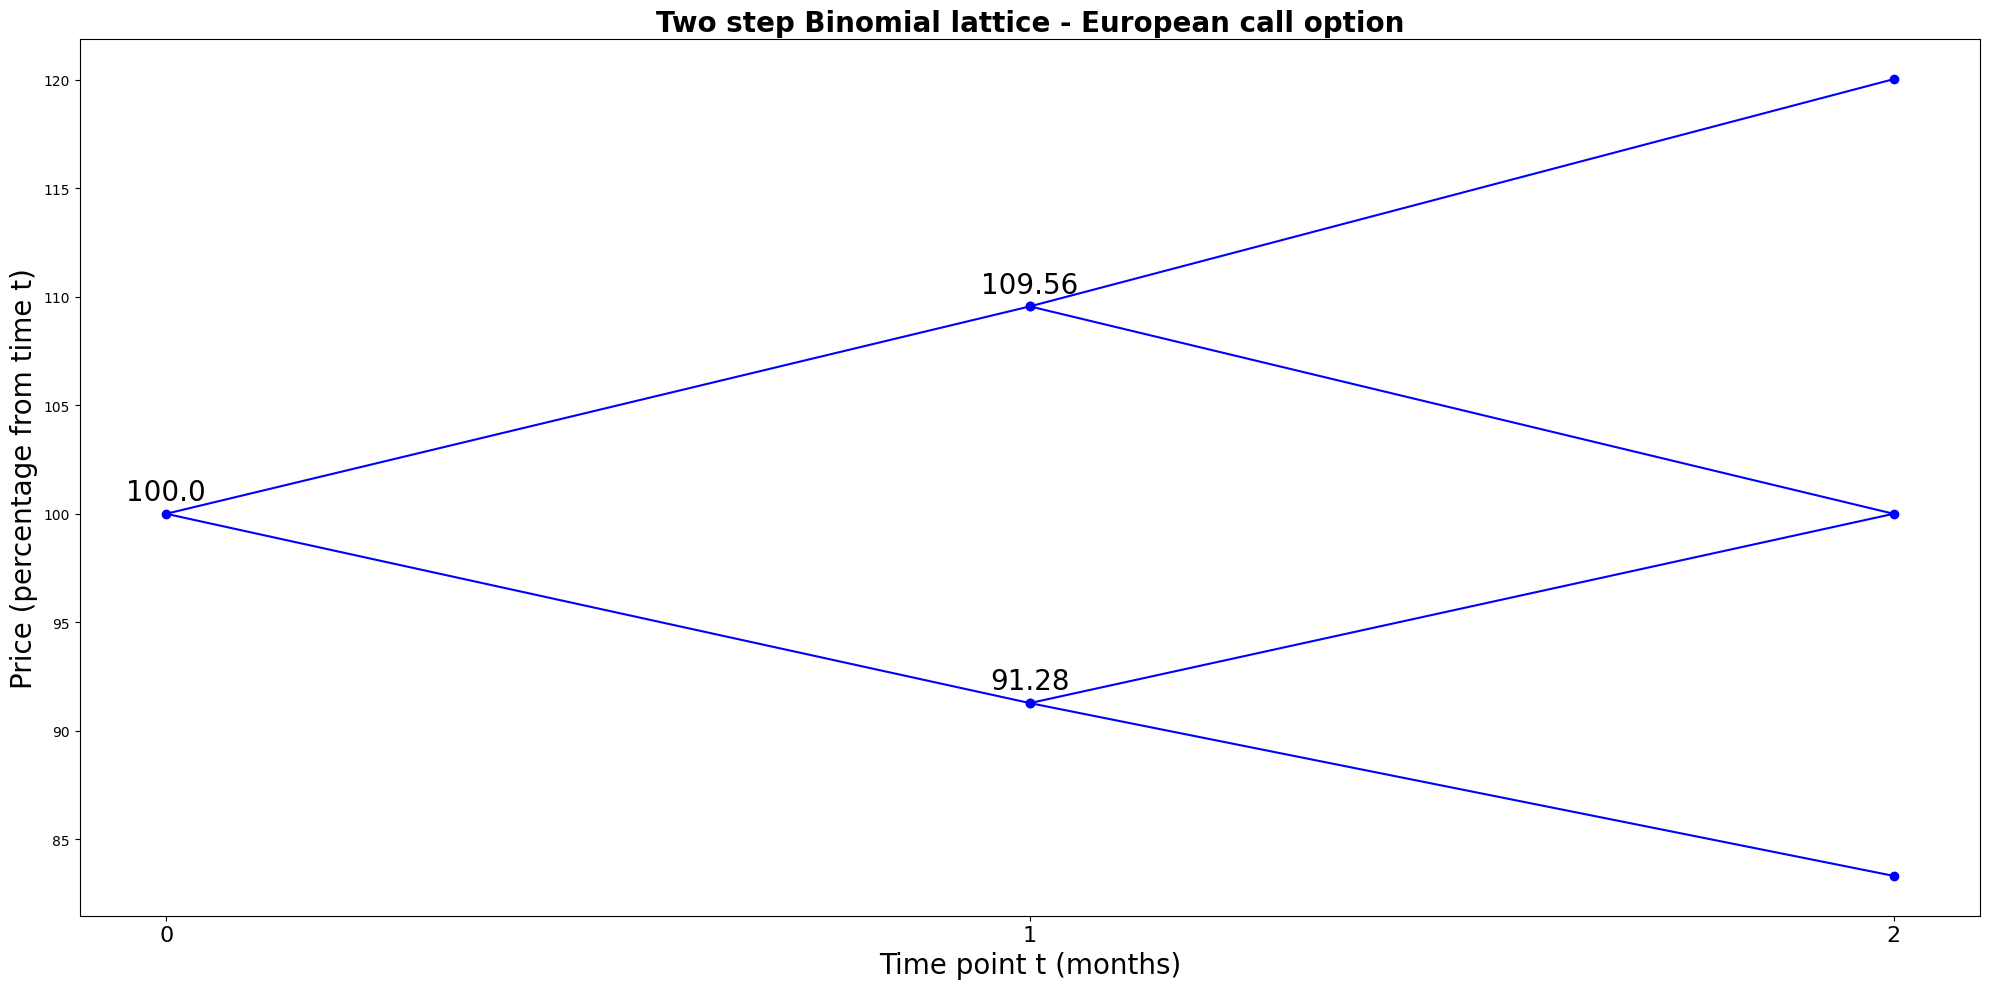

In [15]:
fig = plt.figure(figsize=[20, 10])
for i in range(2):
    x = [1, 0, 1]
    for j in range(i):
        x.append(0)
        x.append(1)
    x = np.array(x) + i
    y = np.arange(-(i+1), i+2)[::-1]
    y = 100 * np.power(up, y)
    plt.plot(x, y, 'bo-')
    if i % 2 == 0:
        for x_pos, y_value in zip(x,y):
            plt.annotate(y_value.round(2), 
                         (x_pos, y_value), 
                         textcoords="offset points",
                         xytext=(0, 10), 
                         ha='center', fontsize=20)
plt.xlabel('Time point t (months)', fontsize=20)
plt.ylabel('Price (percentage from time t)', fontsize=20)
plt.xticks([0, 1, 2], fontsize=16)
plt.title('Two step Binomial lattice - European call option', fontsize=20, weight='bold')
plt.tight_layout()

# Black Scholes Model

Formula to derive the price of an option.

Black-Scholes Formula



For a Put Option:
𝑃
=
𝐾
𝑒
−
𝑟
𝑇
𝑁
(
−
𝑑
2
)
−
𝑆
0
𝑁
(
−
𝑑
1
)
P=Ke 
−rT
 N(−d 
2
​
 )−S 
0
​
 N(−d 
1
​
 )
Where:

𝐶
C: Call option price

𝑃
P: Put option price

𝑆
0
S 
0
​
 : Current price of the underlying asset

𝐾
K: Strike price of the option

𝑇
T: Time to expiration (in years)

𝑟
r: Risk-free interest rate (annualized)

𝜎
σ: Volatility of the underlying asset (standard deviation of returns)

𝑁
(
⋅
)
N(⋅): Cumulative distribution function of the standard normal distribution



In [24]:
class BlackScholes:
    """
    class to compute a european call option and put prices.
    """ 
    @staticmethod
    def d1(stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        return (1 / (volatility * np.sqrt(expiration_time))) * (np.log(stock_price/strike_price) + (risk_free_rate + volatility**2 / 2) * expiration_time)
    
    def d2(self, stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        return self.d1(stock_price, strike_price, expiration_time, risk_free_rate, volatility) - volatility * np.sqrt(expiration_time)
    
    def call_price(self, stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        """ Main method for calculating price of a call option """
        d1 = self.d1(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        d2 = self.d2(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        return norm.cdf(d1) * stock_price - norm.cdf(d2) * strike_price * np.exp(-risk_free_rate*expiration_time)
    
    def put_price(self, stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        """ Main method for calculating price of a put option """
        d1 = self.d1(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        d2 = self.d2(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        return norm.cdf(-d2) * strike_price * np.exp(-risk_free_rate*expiration_time) - norm.cdf(-d1) * stock_price
    
    def call_in_the_money(self, stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        """ 
        Calculate probability that call option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self.d2(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        return norm.cdf(d2)
    
    def put_in_the_money(self, stock_price, strike_price, expiration_time, risk_free_rate, volatility):
        """ 
        Calculate probability that put option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self.d2(stock_price, strike_price, expiration_time, risk_free_rate, volatility)
        return 1 - norm.cdf(d2)

In [25]:
stock_price = 44 
strike_price = 45 
time = 2/12 
risk_free_rate = 0.06 
volatility = np.sqrt(0.2) 

In [26]:
BlackScholes().call_price(stock_price, strike_price, time, risk_free_rate, volatility)

2.9518170207100383

In [27]:
BlackScholes().put_price(stock_price, strike_price, time, risk_free_rate, volatility)

3.5040595394226024

# Probability of options ending in money

Black Scholes computation for theoretical probability of an option ending in the money with a value at expiration. For a call option the stock price is higher than the strike price. Vice versa for put options.

In [28]:
BlackScholes().call_in_the_money(stock_price, strike_price, time, risk_free_rate, volatility)

0.43659661712317027

In [29]:
BlackScholes().put_in_the_money(stock_price, strike_price, time, risk_free_rate, volatility)

0.5634033828768297

# Implied Volatility

Computing the black scholes implied volatiltiy

In [30]:
def call_implied_volatility(price, stock_price, strike_price, time, risk_free_return):
    """ Calculate implied volatility of a call option up to 2 decimals of precision. """
    vol = 0.0001
    while vol < 1:
        d1 = BlackScholes().d1(stock_price, strike_price, time, risk_free_return, vol)
        d2 = BlackScholes().d2(stock_price, strike_price, time, risk_free_return, vol)
        price_implied = stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_return*time) * norm.cdf(d2)
        if price - price_implied < 0.0001:
            return vol
        vol += 0.0001
    return "Not Found"

def put_implied_volatility(price, stock_price, strike_price, time, risk_free_return):
    """ Calculate implied volatility of a put option up to 2 decimals of precision. """
    vol = 0.0001
    while vol < 1:
        call = BlackScholes().call_price(stock_price, strike_price, time, risk_free_return, vol)
        price_implied = strike_price * np.exp(-risk_free_return*time) - stock_price + call
        if price - price_implied < 0.0001:
            return vol
        vol += 0.0001
    return "Not Found"

## Value-at-Risk (VaR)

This represents Value at Risk to express how much of the investment lost is within a given confidence interval e.g. 95%. Requires a probabilty distribution, Log Normal.

In [33]:
initial_investment = 150000
portfolio_mean = 0.4
portfolio_std = np.sqrt(0.0045)

# Portfolio Stats
mean_investment = (1 + portfolio_mean) * initial_investment
std_investment = portfolio_std * initial_investment

# confidence intervals (95%, 98% and 99%)
cutoff1 = norm.ppf(0.05, mean_investment, std_investment)
cutoff2 = norm.ppf(0.02, mean_investment, std_investment)
cutoff3 = norm.ppf(0.01, mean_investment, std_investment)

# Calculate VaR 
VaR5 = initial_investment - cutoff1
VaR2 = initial_investment - cutoff2
VaR1 = initial_investment - cutoff3

In [34]:
print(f"The total value at risk (VaR) with 95% confidence is: {VaR5.round(2)}")
print(f"The total value at risk (VaR) with 98% confidence is: {VaR2.round(2)}")
print(f"The total value at risk (VaR) with 99% confidence is: {VaR1.round(2)}")

The total value at risk (VaR) with 95% confidence is: -43448.98
The total value at risk (VaR) with 98% confidence is: -39334.55
The total value at risk (VaR) with 99% confidence is: -36591.58
